feature: thumb, index, middle, ring, little

length: 64

shape : $N_{sample} \times 64 \times 5$

| layer | shape | result | Activate |
| --- | --- | --- | --- |
| Input | $N_{sample} \times 5 \times 64$ |  | |
| Conv1D_1 | $F \times K$ | $N_{sample} \times F \times 64$ | Relu | 
| MaxPool | $2$ | $N_{sample} \times F \times 32$ |  |
| Conv1D_2 | $2F \times K$ | $N_{sample} \times 2F \times 32$ | Relu |
| MaxPool | $2$ | $N_{sample} \times 2F \times 16$ | |
| FC | $N_{class} \times 32F$ | $N_{sample} \times N_{class}$ | Sigmoid |
| SoftMax |  | $N_{sample} \times N_{class}$ | |



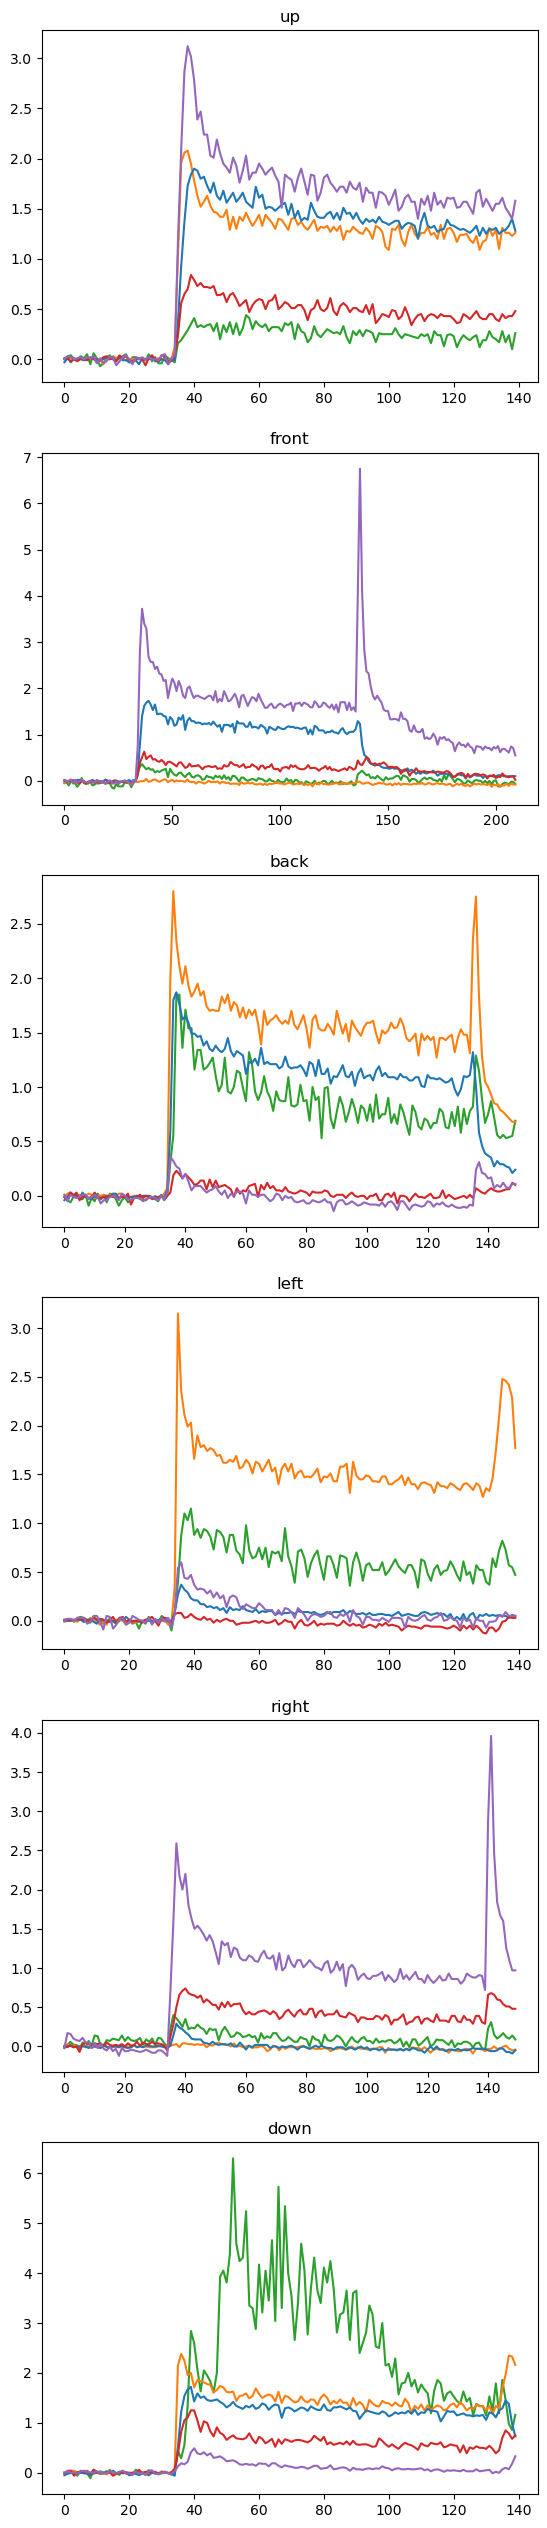

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 


fig, subplots = plt.subplots(nrows=6)
directions = (
    'up',
    'front',
    'back',
    'left',
    'right',
    'down'    
)
fig.set_figheight(32)
plt.plot()

ds = list(os.walk('Dataset'))
for i in range(0, 6):
    subplots[i].set_title(directions[i])

    dir, _, file = ds[i + 1]
    print()
    csv = os.path.join(dir, file[0])
    df = pd.read_csv(csv)
    subplots[i].plot(df['time'], df['thumb'], 'tab:green')
    subplots[i].plot(df['time'], df['index'], 'tab:orange')
    subplots[i].plot(df['time'], df['middle'], 'tab:blue')
    subplots[i].plot(df['time'], df['ring'], 'tab:red')
    subplots[i].plot(df['time'], df['little'], 'tab:purple')
    


In [177]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset

class2num = {'__up_': 0, 'back_': 1, 'down_': 2, 'front': 3, 'left_': 4, 'right': 5}
im = np.eye(6)
# im = im.reshape(6, -1, 6)
print(im.shape)

class MyDataset(Dataset):
    def __init__(self, path: str = 'Dataset', frame_length: int = 16):
        self.filenames = []
        self.category = []
        self.data = np.ndarray([0, frame_length, 5])
        self.label = np.ndarray([0, 6])
        # 파일 경로 로딩
        for dirname, _, filenames in os.walk(path):
            if len(filenames) == 0: continue
            _, category = os.path.split(dirname)
            self.filenames += [os.path.join(dirname, filename) for filename in filenames]
            self.category += [category] * len(filenames)
        
        # # csv 로딩
        for idx, file in enumerate(self.filenames):
            frame = pd.read_csv(file)
            frame = frame[['thumb', 'index', 'middle', 'ring', 'little']][50:114].to_numpy()
            frame = frame.reshape(-1, frame_length, 5)
            self.data = np.append(self.data, frame, axis=0)
            
            self.label = np.append(self.label, [im[class2num[self.category[idx]]]] * int(64 / frame_length), axis=0)

        print(self.data.shape, self.label.shape)
        # Norm
        mean = self.data.mean(axis=0)
        std = self.data.std(axis=0)

        self.data = (self.data - mean) / std

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data[idx])
        y = torch.FloatTensor(self.label[idx])
        return x, y
    
MyDataset()

(6, 6)
(216, 16, 5) (216, 6)


In [191]:
from torch.utils.data import DataLoader, random_split

dataset = MyDataset()
dataset_length = len(dataset)
train_length = int(dataset_length * 0.8)
test_length = int(dataset_length * 0.1)
valid_length = dataset_length - train_length - test_length
train_dataset, test_dataset, validation_dataset = random_split(dataset, [train_length, test_length, valid_length])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(validation_dataset, batch_size=8, shuffle=True)

print(train_length)
print(test_length)
print(valid_length)

(216, 16, 5) (216, 6)
172
21
23


In [192]:
import torch.nn as nn
import torch
from torch.nn import Module, Sequential

class MyModel(Module):
    def __init__(self, filter_size: int = 8):
        super(MyModel, self).__init__()

        self.layer_1 = Sequential(*[
            nn.Conv1d(5, filter_size, 3, padding=1),
            nn.BatchNorm1d(filter_size),
            nn.ReLU(),
            nn.MaxPool1d(2)
        ])

        self.layer_2 = Sequential(*[
            nn.Conv1d(filter_size, 2 * filter_size, 3, padding=1),
            nn.BatchNorm1d(2 * filter_size),
            nn.ReLU(),
            nn.MaxPool1d(2)
        ])

        self.fc = Sequential(*[
            nn.Flatten(),
            nn.Linear(8 * filter_size, 6),
            nn.Sigmoid(),
            nn.Softmax(dim=1)
        ])

        self.drop = nn.Dropout()

    def forward(self, input: torch.FloatTensor):
        out_1 = self.layer_1(input.transpose(1, 2))
        out_2 = self.layer_2(
            self.drop(out_1) if self.training else out_1
        )
        return self.fc(out_2)

In [193]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from pytorch_model_summary import summary

model = MyModel(filter_size=4)
loss_fn = CrossEntropyLoss()
optimizer = Adam(model.parameters())

print(summary(model, torch.FloatTensor(size=(32, 16, 5))))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Conv1d-1         [32, 4, 16]              64              64
     BatchNorm1d-2         [32, 4, 16]               8               8
            ReLU-3         [32, 4, 16]               0               0
       MaxPool1d-4          [32, 4, 8]               0               0
          Conv1d-5          [32, 8, 8]             104             104
     BatchNorm1d-6          [32, 8, 8]              16              16
            ReLU-7          [32, 8, 8]               0               0
       MaxPool1d-8          [32, 8, 4]               0               0
         Flatten-9            [32, 32]               0               0
         Linear-10             [32, 6]             198             198
        Sigmoid-11             [32, 6]               0               0
        Softmax-12             [32, 6]               0               0
Total

In [201]:
from tqdm import tqdm
import matplotlib.pyplot as plt



loss_gp = []
acc_gp = []
with torch.device('cuda' if torch.cuda.is_available() else 'cpu') as device:
    for epoch in tqdm(range(3000)):
        for ((train_data, train_label), (vaild_data, valid_label)) in zip(train_loader, valid_loader):
            print(train_data.get_device())
            model.train(True)
            optimizer.zero_grad()
            train_output = model(train_data)
            loss = loss_fn(train_output, train_label)

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                model.train(False)
                valid_output = model(vaild_data)
                valid_loss = loss_fn(valid_output, valid_label)
                pred = valid_output.argmax(dim=1)
                target = valid_label.argmax(dim=1)

                train_acc = torch.sum(pred == target)
                if epoch == 99:
                    print(list(zip(valid_output, valid_label)))
                loss_gp += [valid_loss]
                acc_gp += [train_acc / pred.shape[0]]

fig, (l, a) = plt.subplots(ncols=2)

l.plot(loss_gp)
a.plot(acc_gp)
print(acc_gp)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 12/3000 [00:00<00:48, 61.21it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  1%|          | 19/3000 [00:00<00:46, 63.89it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  1%|          | 33/3000 [00:00<00:50, 59.05it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  2%|▏         | 45/3000 [00:00<00:53, 54.98it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  2%|▏         | 51/3000 [00:00<00:54, 54.10it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  2%|▏         | 63/3000 [00:01<01:00, 48.63it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  2%|▏         | 73/3000 [00:01<01:06, 43.79it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  3%|▎         | 78/3000 [00:01<01:08, 42.49it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  3%|▎         | 88/3000 [00:01<01:04, 44.87it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  3%|▎         | 100/3000 [00:01<01:00, 48.25it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
[(tensor([0.1297, 0.1296, 0.1295, 0.3521, 0.1295, 0.1295]), tensor([0., 0., 0., 1., 0., 0.])), (tensor([0.1296, 0.1296, 0.3522, 0.1296, 0.1296, 0.1296]), tensor([0., 0., 1., 0., 0., 0.])), (tensor([0.1296, 0.1295, 0.1296, 0.1296, 0.1298, 0.3519]), tensor([0., 0., 0., 0., 0., 1.])), (tensor([0.1296, 0.1295, 0.1296, 0.1296, 0.1298, 0.3519]), tensor([0., 0., 0., 0., 0., 1.])), (tensor([0.1296, 0.1295, 0.1296, 0.1296, 0.1298, 0.3519]), tensor([0., 0., 0., 0., 0., 1.])), (tensor([0.1296, 0.1295, 0.1296, 0.1296, 0.1298, 0.3519]), tensor([0., 0., 0., 0., 0., 1.])), (tensor([0.1296, 0.1296, 0.3522, 0.1296, 0.1296, 0.1296]), tensor([0., 0., 1., 0., 0., 0.])), (tensor([0.1296, 0.1296, 0.1296, 0.1296, 0.3522, 0.1296]), tensor([0., 0., 0., 0., 1., 0.]))]
-1
[(tensor([0.1296, 0.1296, 0.1295, 0.3521, 0.1295, 0.1295]), tensor([0., 0., 0., 1., 0., 0.])), (tensor([0.1296, 0.1296, 0.1296, 0.1296, 0.3522, 0.1296]), tensor([0., 0., 0., 0., 1., 0.]))

  4%|▍         | 113/3000 [00:02<00:54, 53.44it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  4%|▍         | 126/3000 [00:02<00:50, 56.36it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  4%|▍         | 132/3000 [00:02<00:52, 54.62it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  5%|▍         | 144/3000 [00:02<00:57, 49.30it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  5%|▌         | 156/3000 [00:03<00:54, 51.92it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  6%|▌         | 168/3000 [00:03<00:54, 52.04it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  6%|▌         | 180/3000 [00:03<00:50, 55.48it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  6%|▌         | 186/3000 [00:03<01:03, 44.38it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  7%|▋         | 196/3000 [00:03<01:00, 46.39it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  7%|▋         | 201/3000 [00:04<01:06, 41.81it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  7%|▋         | 212/3000 [00:04<01:02, 44.28it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  7%|▋         | 224/3000 [00:04<00:55, 50.00it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  8%|▊         | 237/3000 [00:04<00:50, 54.65it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  8%|▊         | 249/3000 [00:04<00:50, 54.02it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  9%|▊         | 256/3000 [00:05<00:48, 56.78it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


  9%|▉         | 271/3000 [00:05<00:43, 62.49it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


 10%|▉         | 285/3000 [00:05<00:44, 60.61it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


 10%|▉         | 298/3000 [00:05<00:46, 58.44it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


 10%|█         | 312/3000 [00:05<00:43, 61.33it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


 11%|█         | 319/3000 [00:06<00:44, 59.68it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


 11%|█         | 331/3000 [00:06<00:49, 54.42it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


 12%|█▏        | 345/3000 [00:06<00:44, 60.30it/s]

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


 12%|█▏        | 351/3000 [00:06<00:49, 53.01it/s]


-1
-1
-1
-1
-1
-1


KeyboardInterrupt: 

In [175]:
with torch.no_grad():
    for (data, label) in test_loader:
        output = model(data)
        print(output.argmax(dim=1))
        print(label.argmax(dim=1))

tensor([1, 1, 3, 2, 4, 0, 2, 4])
tensor([1, 1, 5, 2, 4, 0, 2, 4])
tensor([3, 2, 0, 3, 3, 3, 4, 3])
tensor([3, 2, 0, 5, 3, 3, 4, 5])
tensor([3, 3, 3, 2, 1])
tensor([5, 3, 3, 2, 1])
